# Ejemplo de ROC Curve

Los datos fueron descargados de: https://www.kaggle.com/blastchar/telco-customer-churn

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb # Si no lo tienen instalado: conda install xgboost

import matplotlib.pyplot as plt 
from IPython.display import Image
import pydotplus # Si no lo tienen instalado: conda install -c conda-forge pydotplus

### Importamos los datos

In [2]:
data = pd.read_csv('telcoChurn.csv')

In [3]:
#Imputamos los nulos que figuran como "vacios"
data['TotalCharges'] = data['TotalCharges'].replace(' ',-1).astype(float)

### Convertirmos las variables categóricas a Dummies

In [4]:
# Seleccionamos las variables categóricas
cat_vars = ['gender', 'Partner', 'Dependents', 'PhoneService','MultipleLines', 'InternetService',
           'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
           'PaymentMethod']

In [5]:
# Iteramos sobre cada variable creando su dummie         
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

In [6]:
# Descartamos las variables originales
data = data.drop(cat_vars, axis = 1)

In [7]:
# El target también los convertimos en una variable numérica dummie
data['target'] = np.where(data.Churn == 'Yes',1,0)

In [8]:
# Eliminamos la variable Target y el ID de cliente que no arroja información (realmente no tiene información?)
data = data.drop(['Churn', 'customerID'], axis = 1)

In [9]:
data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,target
0,0,1,29.85,29.85,1,0,0,1,1,0,...,1,0,0,0,1,0,0,1,0,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,...,1,0,0,0,1,0,0,0,1,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,1,0,0,0,1,0,0,1,0,1


### Separamos las bases y creamos un objeto Metricas

In [10]:
# Separamos la base en las columnas Independientes y la Dependiente (X e Y)
X, y = data.drop(data.columns[-1], axis=1), data.iloc[:,-1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
#Guardo un objeto con las metricas de mis modelos
metricas = {}

### Entreno los modelos "simples" de clases anteriores

In [13]:
# Entreno un Arbol de Decision
dtree= DecisionTreeClassifier()
dtree.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = dtree.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['decisionTree'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [14]:
#Entreno una Regresión Logistica
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Me guardo las Metricas que necesito para graficar
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas['logisticRegresion'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Entreno modelos de Baging y Boosting para ver como comparan

In [15]:
#Entreno un Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

# Me guardo las Metricas que necesito para graficar
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas['RandomForest'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [16]:
# Entreno un Modelo de AdaBoost
AdaB = AdaBoostClassifier()
AdaB.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = AdaB.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['AdaBoost'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [17]:
# Entreno un Modelo de Gradient Boosting
GBM = GradientBoostingClassifier()
GBM.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = GBM.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['GradientBoosting'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [18]:
# Entreno un Modelo de XGBoost
# Link de la documentacion de este algoritmo -> https://xgboost.readthedocs.io/en/latest/python/python_api.html
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = xgb_model.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['XGBClassifier'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

### Grafico las curvas ROC de los modelos para Compararlos

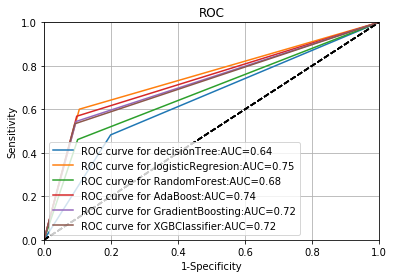

In [19]:
# Grafico la Curva ROC con los valores de mis modelos
for modelName in metricas:
    label = 'ROC curve for {0}:'.format(modelName)
    plt.plot(metricas[modelName]['fpr'], metricas[modelName]['tpr'], label=label+'AUC={0:0.2f}'.format(metricas[modelName]['auc']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--')

plt.grid(True)
plt.title('ROC')
plt.legend(loc="lower left")
plt.show()

### ¿Qué pasaría si comienzo a modificar los parámetros de estos modelos nuevos?

Cambiar los parámetros -> Guardar las nuevas métricas -> Volver a graficar las Curvas ROC

In [20]:
#Entreno un Random Forest
RF = RandomForestClassifier(n_estimators=200, max_depth=10,max_features=0.7, random_state=42, criterion='entropy')
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

# Me guardo las Metricas que necesito para graficar
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas['RandomForest'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [21]:
# Entreno un Modelo de AdaBoost
AdaB = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)
AdaB.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = AdaB.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['AdaBoost'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [22]:
# Entreno un Modelo de Gradient Boosting
GBM = GradientBoostingClassifier(n_estimators=100, subsample=1.0, max_depth=3, init=None, random_state=None)
GBM.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = GBM.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['GradientBoosting'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [23]:
# Entreno un Modelo de XGBoost
# Link de la documentacion de este algoritmo -> https://xgboost.readthedocs.io/en/latest/python/python_api.html
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, feature_names=None, label=None, max_depth=0)

xgb_model.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = xgb_model.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['XGBClassifier'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

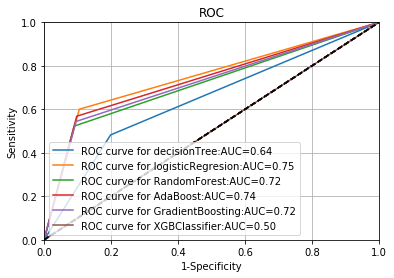

In [24]:
# Grafico la Curva ROC con los valores de mis modelos
for modelName in metricas:
    label = 'ROC curve for {0}:'.format(modelName)
    plt.plot(metricas[modelName]['fpr'], metricas[modelName]['tpr'], label=label+'AUC={0:0.2f}'.format(metricas[modelName]['auc']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--')

plt.grid(True)
plt.title('ROC')
plt.legend(loc="lower left")
plt.show()

### ¿Qué pasaría si optimizo los parámetros con Greedy Search o Random Search?

Optimizar por Greedy/Random Search -> Guardar las nuevas métricas -> Volver a graficar las Curvas ROC

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
import scipy.stats as st

In [26]:
model_xg = XGBClassifier(n_jobs=-1)

In [27]:
one_to_left = st.beta(10, 1)

In [28]:
params = {  
    "n_estimators": st.randint(20,40), # Number of boosted trees to fit.
    "max_depth": st.randint(3, 12),     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
}

In [29]:
xgb = RandomizedSearchCV(model_xg,params, n_iter=50, verbose= True)

In [30]:
xgb.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.0min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a24e9d668>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a24f0ada0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a24fbd8d0>, 'colsample_bytree': <sc...24fbdef0>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a24f87550>},
         

In [31]:
y_predicted_xgb = xgb.predict_proba(X_test)

In [32]:
xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9598578690762694,
       gamma=0.11732972428389887, learning_rate=0.25947570472408055,
       max_delta_step=0, max_depth=5, min_child_weight=18.972390279293798,
       missing=None, n_estimators=20, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0,
       reg_alpha=3.5841798773299236, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.983221009598027, verbosity=1)

In [33]:
xgb_auc = metrics.roc_auc_score(y_test,y_predicted_xgb[:,1])
print("El valor del AUC es: ", xgb_auc)

El valor del AUC es:  0.8613389816472925


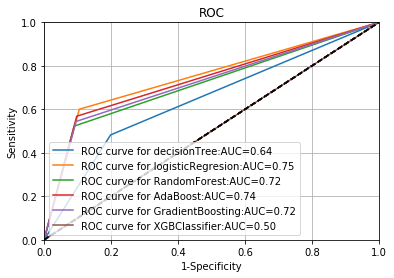

In [34]:
# Grafico la Curva ROC con los valores de mis modelos
for modelName in metricas:
    label = 'ROC curve for {0}:'.format(modelName)
    plt.plot(metricas[modelName]['fpr'], metricas[modelName]['tpr'], label=label+'AUC={0:0.2f}'.format(metricas[modelName]['auc']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--')

plt.grid(True)
plt.title('ROC')
plt.legend(loc="lower left")
plt.show()